## Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '../input/cuhk-face-sketch-database-cufs/photos'
img_array = []

sketch_path = '../input/cuhk-face-sketch-database-cufs/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))
    
    
    
   



    

100%|██████████| 188/188 [00:02<00:00, 76.25it/s]


In [3]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


In [4]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
   
    plt.show()

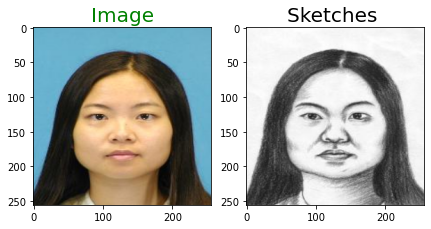

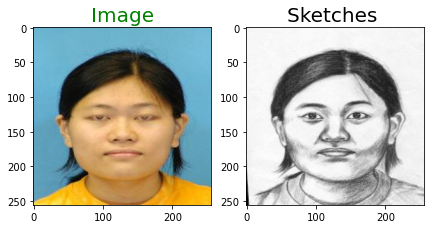

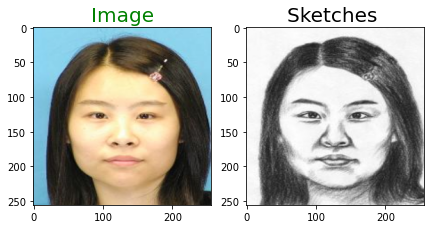

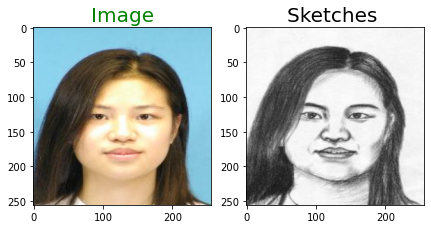

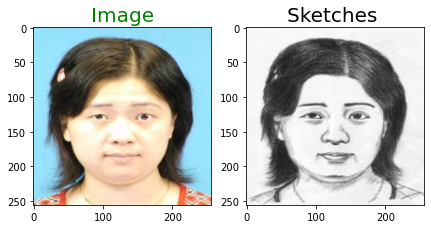

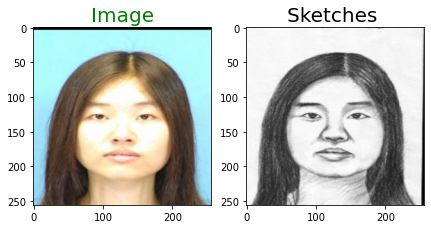

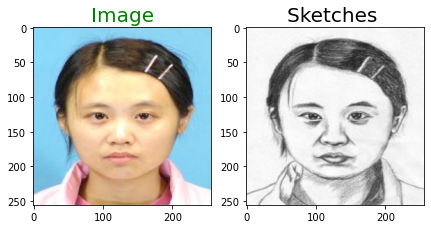

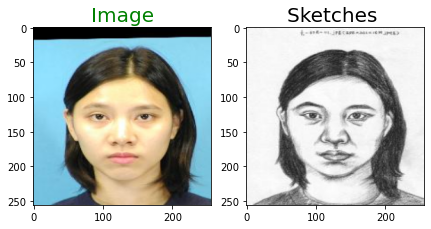

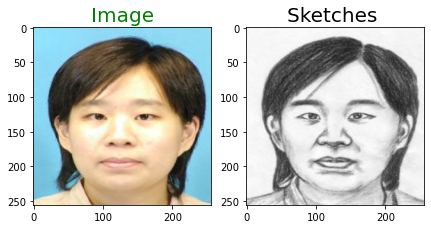

In [5]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])


In [6]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (104, 256, 256, 3)


## Downsample layer

In [7]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

## Upsample Layer

In [8]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

# Model 
Here i have use sequence of downsample layer for encoder and upsample layer for decoder

In [9]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)

        
    
    


In [10]:
# to get summary of model
model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 127, 127, 16)      768       
_________________________________________________________________
sequential_1 (Sequential)    (None, 62, 62, 32)        8320      
_________________________________________________________________
sequential_2 (Sequential)    (None, 30, 30, 64)        32768     
_________________________________________________________________
sequential_3 (Sequential)    (None, 14, 14, 128)       131584    
_________________________________________________________________
sequential_4 (Sequential)    (None, 6, 6, 256)         525312    
_________________________________________________________________
sequential_5 (Sequential)    (None, 2, 2, 512)        

In [11]:
# ## Model
# Here I have defined two blocks of networks. Encoder network takes 256 by 256 image and downsample it to 16 by 16 latent vector
# by passing our image via series of Convolution and Maxpooling layer. This downsampled 16 by 16 latent vector is upsampled by passing 
# through series of Convolution and UpSampling layer. The final decoder output is same as our encoder input. This upsamples output of decoder
# is compared with our sketches and reconstruction loss is calculated. This loss is minimized by updating weight and bias of network through
# backpropagation.
# encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="img")
# x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
# x = MaxPool2D(pool_size = (2,2))(x)

# x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
# x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
# x = MaxPool2D(pool_size = (2,2))(x)

# x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
# x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
# encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
# encoder = tf.keras.Model(encoder_input, encoder_output)

# decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
# x = UpSampling2D(size = (2,2))(decoder_input)
# x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
# x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
# x = UpSampling2D(size = (2,2) )(x)

# x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
# x = UpSampling2D(size = (2,2) )(x)
# x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
# x = UpSampling2D(size = (2,2) )(x)
 
# x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
# decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

# # final model
# model = keras.Model(encoder_input, decoder_output)
# model.summary()

In [30]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_image, train_sketch_image, epochs = 100, verbose = 0)

### Evaluating our model

In [31]:
prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

4/4 [==============================] - 0s 27ms/step - loss: 0.0774 - acc: 0.4923
Loss:  0.07740883529186249
Accuracy:  49.2


# Plotting our predicted sketch along with real sketch

In [32]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

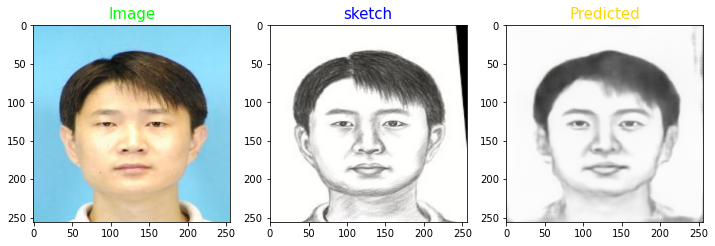

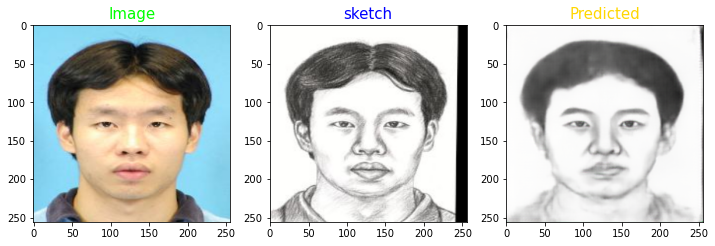

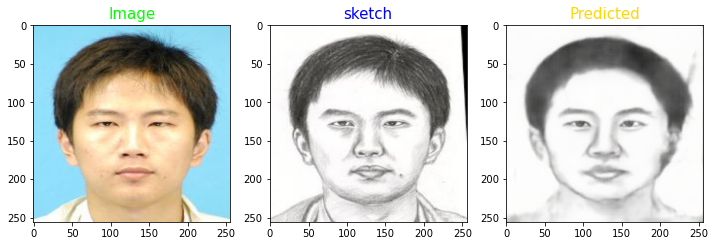

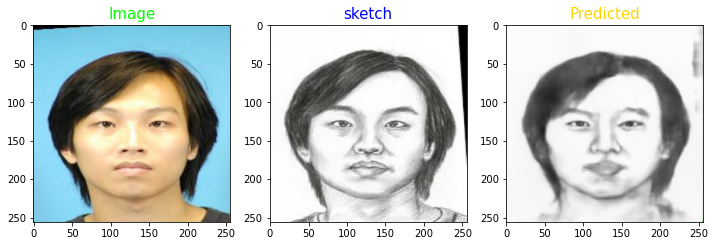

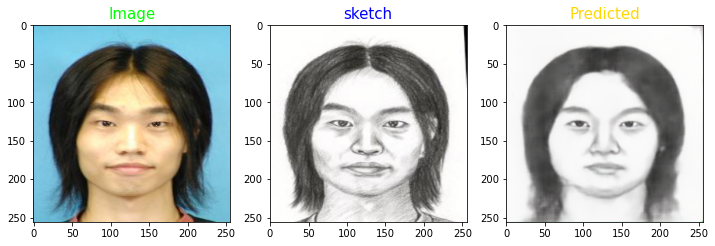

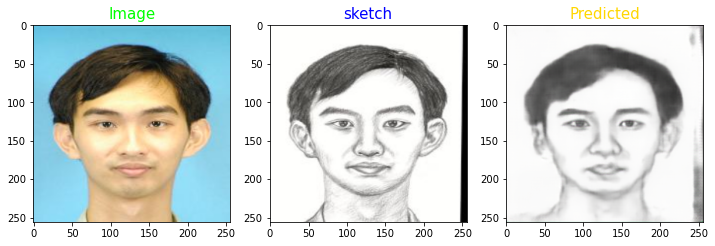

In [ ]:
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)